# BT4012 Fraud Analytics Project

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
from torch_geometric.data import Data
from sknetwork.data import from_edge_list
from sknetwork.clustering import Louvain, get_modularity
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, average_precision_score
from sklearn import metrics

## Importing Data

In [2]:
# Import the training dataset
train = pd.read_csv("fraudTrain.csv", index_col=0)

# Import the testing dataset
test = pd.read_csv("fraudTest.csv", index_col=0)

full_dataset = pd.concat([train, test]).reset_index(drop=True)

In [3]:
txg = pd.melt(full_dataset, id_vars=['cc_num'], value_vars=['category', 'state', 'job'])
txg['TOKEN'] = txg['variable'].astype(str) + "_" + txg["value"].astype(str)
txg = txg[['cc_num', 'TOKEN']].groupby(['cc_num', 'TOKEN']).size().reset_index(name='TF')

# Calculate IDF for each cc_num
usg = txg[['cc_num', 'TOKEN']].groupby(['cc_num']).size().reset_index(name='IDF')

# Calculate TF-IDF for each cc_num and TOKEN combination
txg = txg.merge(usg, on='cc_num')
txg['TF_IDF'] = txg['TF'] / txg['IDF']

# Convert the cc_num and TOKEN combinations into an edge list
edge_list = list(txg.itertuples(index=False))
graph = from_edge_list(edge_list, bipartite=True)

# Extract biadjacency matrix and names
biadjacency = graph.biadjacency
names_row = graph.names_row
names_col = graph.names_col

# Apply the Louvain algorithm
louvain = Louvain(resolution=1.7, modularity='newman')
louvain.fit(biadjacency)

# Extract labels
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

# Calculate and print modularity
print(get_modularity(biadjacency, labels_row, labels_col))

# Aggregate the graph
biadjacency_aggregate = louvain.aggregate_

# Get unique labels and their counts for rows and columns
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)

0.08851268739572865


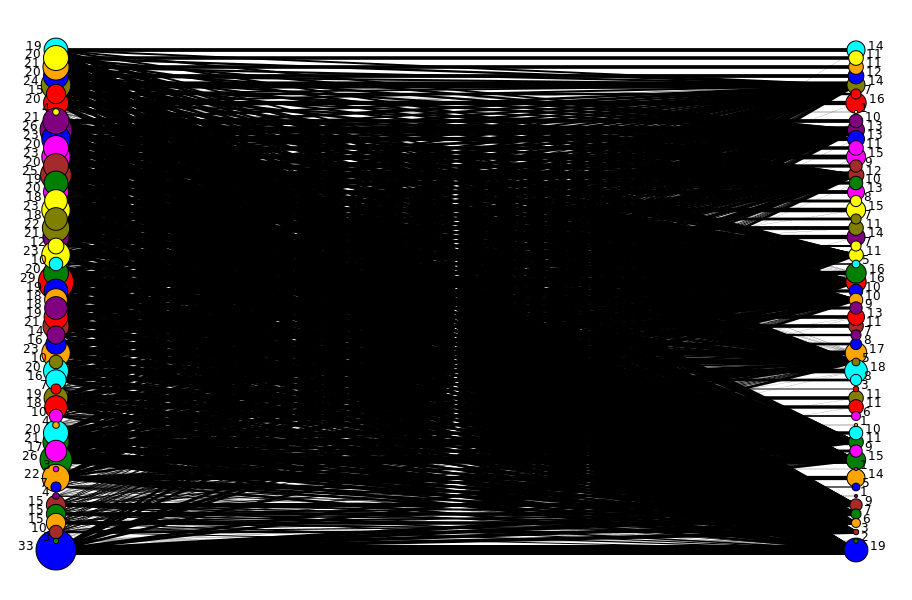

In [4]:
from IPython.display import SVG
from sknetwork.visualization import svg_bigraph
image = svg_bigraph(biadjacency_aggregate, counts_row, counts_col, labels_unique_row, labels_unique_col,
                    display_node_weight=True, node_weights_row=counts_row, node_weights_col=counts_col,
                    scale=0.5, height=1000, width=1600, reorder=True, edge_width_min = 0.0001, margin= 100)
SVG(image)

In [5]:
# Create a dictionary mapping cc_num to Louvain community labels
louv_dict = {name: label for name, label in zip(names_row, labels_row)}

# Apply the Louvain community mapping
train['louvain_community'] = train['cc_num'].map(louv_dict)
test['louvain_community'] = test['cc_num'].map(louv_dict)


In [6]:
train["transaction_dt"] = pd.to_datetime(train["trans_date_trans_time"])
test["transaction_dt"] = pd.to_datetime(test["trans_date_trans_time"])

train["transaction_hour"] = train["transaction_dt"].dt.hour
test["transaction_hour"] = test["transaction_dt"].dt.hour

In [7]:
def display_importances_xgb(model, use_features):
    fmap = {'f'+ str(index): x for index, x in enumerate(use_features, start=0)}
    fimp_df = pd.DataFrame(list(model.get_booster().get_fscore().items()))
    fimp_df.columns = ['feature', 'importance']
    fimp_df['importance']=fimp_df['importance']/np.sum(fimp_df['importance'])
    fimp_df['feature'] = fimp_df['feature'].map(fmap)

    plt.figure(figsize=(14, 10))
    sns.barplot(x="importance", y="feature", data=fimp_df.sort_values(by="importance", ascending=False))
    plt.title('Feature Importance')
    plt.tight_layout()

In [8]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, f1_score

all_columns_to_drop = [
    'trans_date_trans_time', 'cc_num', 'first', 'last', 'street',
    'merchant', 'city', 'job', 'dob', 'transaction_dt', 'lat', 'long',
    'merch_lat', 'merch_long', 'zip',
]

# Split the data into training and validation sets
split_index = int(0.9 * len(train))
train_set = train.iloc[:split_index, :]
validation_set = train.iloc[split_index:, :]

# Drop the columns and separate the target
y_train = train_set['is_fraud']
X_train = train_set.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')
y_validation = validation_set['is_fraud']
X_validation = validation_set.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features_to_impute = [col for col in numeric_features if col != 'louvain_community']
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Define transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_to_impute),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

In [9]:

# Initialize the XGBClassifier with initial hyperparameters
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

xgb_clf = XGBClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1,
    objective='binary:logistic', max_depth=2,
    scale_pos_weight=scale_pos_weight, min_child_weight=80,
    gamma=10, max_delta_step=2
)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', xgb_clf)])

# Train the model on the DataFrame
pipeline.fit(X_train, y_train)

# Get the trained XGBClassifier
trained_model = pipeline.named_steps['model']

# Evaluate on the validation set
y_pred = pipeline.predict(X_validation)
y_pred_proba = pipeline.predict_proba(X_validation)[:, 1]

# Calculate ROC-AUC and F1 score
roc_auc = roc_auc_score(y_validation, y_pred_proba)
f1 = f1_score(y_validation, y_pred)

print(f'ROC-AUC score on the validation set: {roc_auc}')
print(f'F1 score on the validation set: {f1}')
print(metrics.classification_report(y_validation, y_pred))

ROC-AUC score on the validation set: 0.9901154477173723
F1 score on the validation set: 0.23283057548689418
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    128836
           1       0.13      0.96      0.23       832

    accuracy                           0.96    129668
   macro avg       0.57      0.96      0.61    129668
weighted avg       0.99      0.96      0.97    129668



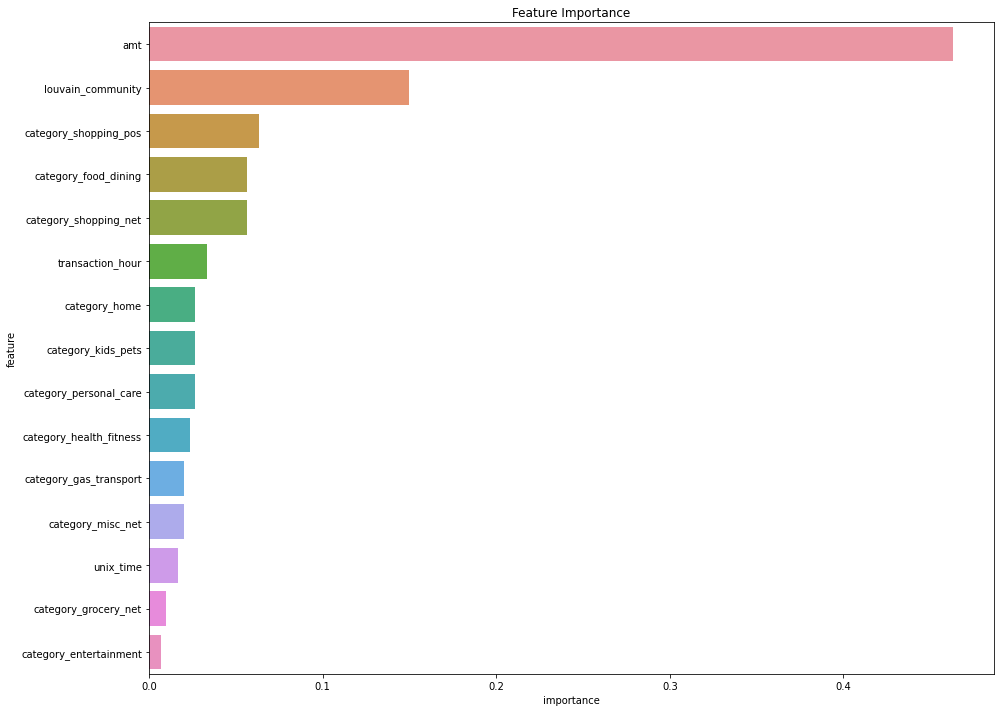

In [10]:
# Get feature names after one-hot encoding
ohe_feature_names = (pipeline.named_steps['preprocessor']
                            .named_transformers_['cat']
                            .named_steps['onehot']
                            .get_feature_names_out(categorical_features))

# Combine numeric and one-hot encoded feature names
features_after_preprocessing = np.append(numeric_features, ohe_feature_names)

# Display feature importances
display_importances_xgb(trained_model, features_after_preprocessing)

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, average_precision_score
from sklearn import metrics

# Define a search space for hyperparameters
param_distributions = {
    'model__n_estimators': randint(50, 200),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(3, 7),
    'model__min_child_weight': randint(1, 6),
    'model__gamma': uniform(0, 0.3),
    'model__max_delta_step': randint(0, 5),
    'model__scale_pos_weight': randint(1, 100)
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring=make_scorer(average_precision_score),
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV to find the best hyperparameters
random_search.fit(X_train, y_train)

# Print the best parameters found
print(f'Best parameters found: {random_search.best_params_}')

# Evaluate the best model found on the validation set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_validation)
y_pred_proba = best_model.predict_proba(X_validation)[:, 1]

# Calculate ROC-AUC and F1 score with the best model
roc_auc = roc_auc_score(y_validation, y_pred_proba)
f1 = f1_score(y_validation, y_pred)
print(f'ROC-AUC score with the best model: {roc_auc}')
print(f'F1 score with the best model: {f1}')
print(metrics.classification_report(y_validation, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'model__gamma': 0.013999698964084628, 'model__learning_rate': 0.10737555188414592, 'model__max_delta_step': 2, 'model__max_depth': 6, 'model__min_child_weight': 4, 'model__n_estimators': 113, 'model__scale_pos_weight': 3}
ROC-AUC score with the best model: 0.9972843335638988
F1 score with the best model: 0.7968176254589963
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128836
           1       0.81      0.78      0.80       832

    accuracy                           1.00    129668
   macro avg       0.91      0.89      0.90    129668
weighted avg       1.00      1.00      1.00    129668



In [12]:

y_test = test['is_fraud']
X_test = test.drop(columns=all_columns_to_drop + ['is_fraud'], axis=1, errors='ignore')

y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

# Calculate the final ROC-AUC and F1 score for the test set
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
f1_test = f1_score(y_test, y_pred_test)

print(f'Final ROC-AUC score on the test set: {roc_auc_test}')
print(f'Final F1 score on the test set: {f1_test}')
print(metrics.classification_report(y_test, y_pred_test))

Final ROC-AUC score on the test set: 0.9951730742302554
Final F1 score on the test set: 0.7385873268226211
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.72      0.76      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.88      0.87    555719
weighted avg       1.00      1.00      1.00    555719

